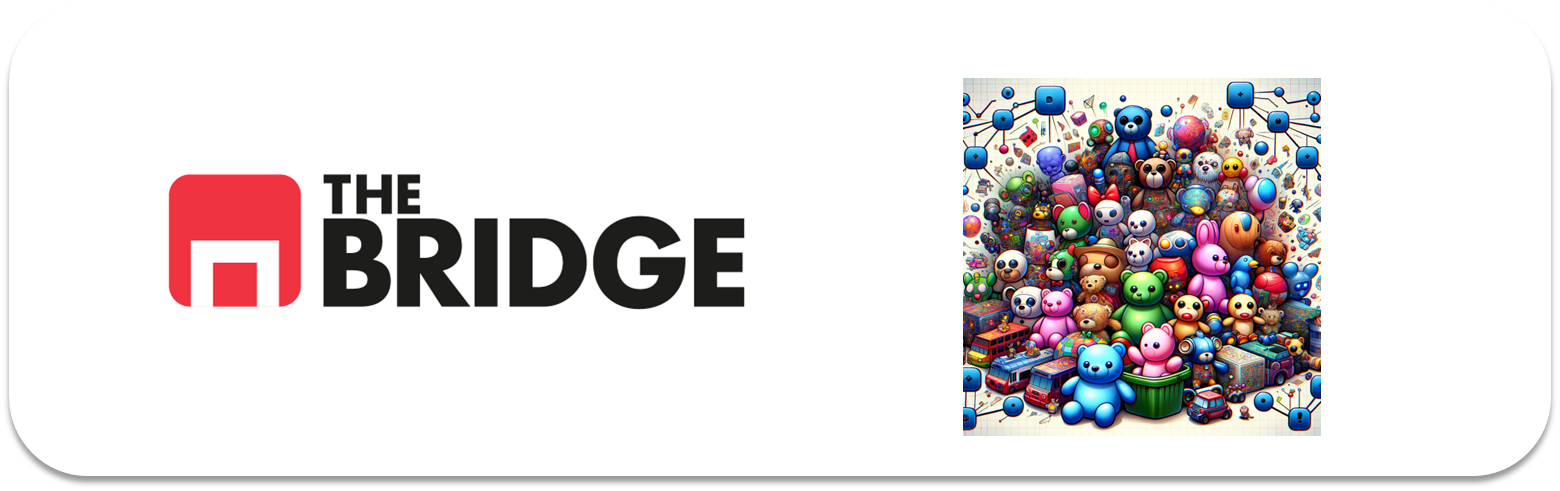

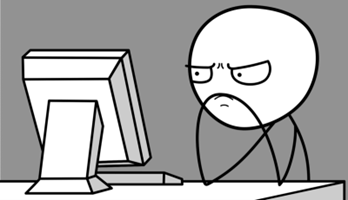

## PRACTICA OBLIGATORIA: K-MEANS

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [2]:
from sklearn.datasets import fetch_olivetti_faces

# Cargamos el dataset de rostros Olivetti
faces = fetch_olivetti_faces()

# Mostramos la descripción del dataset
print(faces.DESCR)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\migue\scikit_learn_data
.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for s

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [6]:
import pandas as pd

# Crear un DataFrame con los datos (imágenes aplanadas) y el target
df = pd.DataFrame(faces.data)
df['target'] = faces.target

# Mostrar las primeras filas del DataFrame para comprobar
print("\nPrimeras filas del DataFrame original:")
print(df.head())

# Reordenar aleatoriamente las filas del DataFrame
df_random = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nPrimeras filas del DataFrame reordenado aleatoriamente:")
print(df_random.head())



Primeras filas del DataFrame original:
          0         1         2         3         4         5         6  \
0  0.309917  0.367769  0.417355  0.442149  0.528926  0.607438  0.657025   
1  0.454545  0.471074  0.512397  0.557851  0.595041  0.640496  0.681818   
2  0.318182  0.400826  0.491736  0.528926  0.586777  0.657025  0.681818   
3  0.198347  0.194215  0.194215  0.194215  0.190083  0.190083  0.243802   
4  0.500000  0.545455  0.582645  0.623967  0.648760  0.690083  0.694215   

          7         8         9  ...      4087      4088      4089      4090  \
0  0.677686  0.690083  0.685950  ...  0.669421  0.652893  0.661157  0.475207   
1  0.702479  0.710744  0.702479  ...  0.157025  0.136364  0.148760  0.152893   
2  0.685950  0.702479  0.698347  ...  0.132231  0.181818  0.136364  0.128099   
3  0.404959  0.483471  0.516529  ...  0.636364  0.657025  0.685950  0.727273   
4  0.714876  0.723140  0.731405  ...  0.161157  0.177686  0.173554  0.177686   

       4091      4092      4

### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [7]:
# Separamos las columnas de features y la columna 'target'
X = df_random.drop('target', axis=1)
y = df_random['target']

# Imprimimos las dimensiones para verificar
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (400, 4096)
Dimensiones de y: (400,)


In [8]:
from sklearn.model_selection import train_test_split

# Dividimos los datos en 80% entrenamiento y 20% temporal (para validación y test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.2,       # 20% para el conjunto temporal
    stratify=y,          # Estratificar para mantener la proporción de clases
    random_state=42      # Fijamos la semilla para reproducibilidad
)

# Verificamos las dimensiones de los conjuntos
print("Conjunto de entrenamiento - X_train:", X_train.shape, "y_train:", y_train.shape)
print("Conjunto temporal - X_temp:", X_temp.shape, "y_temp:", y_temp.shape)


Conjunto de entrenamiento - X_train: (320, 4096) y_train: (320,)
Conjunto temporal - X_temp: (80, 4096) y_temp: (80,)


In [9]:
# Dividimos el conjunto temporal en dos conjuntos: validación y test
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,       # Dividimos X_temp en dos partes iguales
    stratify=y_temp,     # Estratificar de nuevo para mantener la proporción
    random_state=42      # Usamos la misma semilla para reproducibilidad
)

# Verificamos las dimensiones de cada conjunto
print("Conjunto de validación - X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
print("Conjunto de test - X_test:", X_test.shape, "y_test:", y_test.shape)


Conjunto de validación - X_valid: (40, 4096) y_valid: (40,)
Conjunto de test - X_test: (40, 4096) y_test: (40,)


In [10]:
print("Total de ejemplos en X:", X.shape[0])
print("Ejemplos en entrenamiento:", X_train.shape[0])
print("Ejemplos en validación:", X_valid.shape[0])
print("Ejemplos en test:", X_test.shape[0])


Total de ejemplos en X: 400
Ejemplos en entrenamiento: 320
Ejemplos en validación: 40
Ejemplos en test: 40


### #1.4

Crea los pares X,y para train, validation y test.

In [12]:
# Creamos tuplas (pares) para cada conjunto
train_pair = (X_train, y_train)
valid_pair = (X_valid, y_valid)
test_pair = (X_test, y_test)

# Imprimimos 
print("Pares de datos creados:")
print("Train:", train_pair[0].shape, train_pair[1].shape)
print("Validation:", valid_pair[0].shape, valid_pair[1].shape)
print("Test:", test_pair[0].shape, test_pair[1].shape)


Pares de datos creados:
Train: (320, 4096) (320,)
Validation: (40, 4096) (40,)
Test: (40, 4096) (40,)


Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [14]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

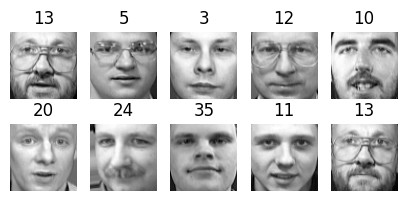

In [15]:
# Convertir las primeras 10 imágenes del conjunto de entrenamiento a un array numpy
faces_to_plot = X_train.iloc[:10].values  # Obtiene las primeras 10 filas como un array
labels_to_plot = y_train.iloc[:10].values   # Obtiene las primeras 10 etiquetas

# Llamamos a la función para visualizar las imágenes
plot_faces(faces_to_plot, labels_to_plot, n_cols=5)


### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

np.int64(221)

In [18]:
print("Número de componentes retenidos:", pca.n_components_)


Número de componentes retenidos: 221


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}

for k in range(5, 151, 5):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_pca)
    labels = km.labels_
    score = silhouette_score(X_train_pca, labels)
    scores[k] = score
    print(f"k = {k}, silhouette score = {score:.4f}")

best_k = max(scores, key=scores.get)
print(f"\nEl mejor k es: {best_k} con un silhouette score de {scores[best_k]:.4f}")


c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\migue\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

k = 5, silhouette score = 0.1086
k = 10, silhouette score = 0.0918
k = 15, silhouette score = 0.0801
k = 20, silhouette score = 0.1034
k = 25, silhouette score = 0.1114
k = 30, silhouette score = 0.1248
k = 35, silhouette score = 0.1406
k = 40, silhouette score = 0.1508
k = 45, silhouette score = 0.1597
k = 50, silhouette score = 0.1710
k = 55, silhouette score = 0.1627
k = 60, silhouette score = 0.1730
k = 65, silhouette score = 0.1701
k = 70, silhouette score = 0.1699
k = 75, silhouette score = 0.1809
k = 80, silhouette score = 0.1851
k = 85, silhouette score = 0.1924
k = 90, silhouette score = 0.1860
k = 95, silhouette score = 0.1876
k = 100, silhouette score = 0.1921
k = 105, silhouette score = 0.1892
k = 110, silhouette score = 0.1913
k = 115, silhouette score = 0.1935
k = 120, silhouette score = 0.1931
k = 125, silhouette score = 0.1928
k = 130, silhouette score = 0.1941
k = 135, silhouette score = 0.1954
k = 140, silhouette score = 0.1898
k = 145, silhouette score = 0.1900
k = 1

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?

In [20]:
inertias = {}

for k in range(5, 151, 5):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_train_pca)
    inertias[k] = km.inertia_
    print(f"k = {k}, inertia = {km.inertia_:.2f}")


k = 5, inertia = 17034.63
k = 10, inertia = 14948.45
k = 15, inertia = 13973.87
k = 20, inertia = 12499.55
k = 25, inertia = 11590.90
k = 30, inertia = 10677.71
k = 35, inertia = 9852.68
k = 40, inertia = 9141.87
k = 45, inertia = 8523.20
k = 50, inertia = 8007.92
k = 55, inertia = 7773.29
k = 60, inertia = 7251.33
k = 65, inertia = 6929.95
k = 70, inertia = 6670.21
k = 75, inertia = 6228.45
k = 80, inertia = 5865.90
k = 85, inertia = 5548.37
k = 90, inertia = 5332.62
k = 95, inertia = 5119.63
k = 100, inertia = 4832.76
k = 105, inertia = 4649.01
k = 110, inertia = 4405.13
k = 115, inertia = 4154.64
k = 120, inertia = 3959.35
k = 125, inertia = 3747.08
k = 130, inertia = 3524.58
k = 135, inertia = 3359.88
k = 140, inertia = 3206.10
k = 145, inertia = 3025.66
k = 150, inertia = 2761.41


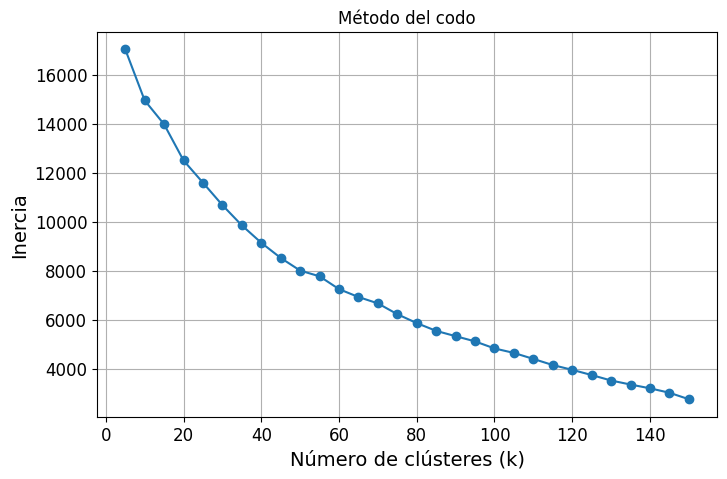

In [21]:
import matplotlib.pyplot as plt

# Convertir las keys y values del diccionario en listas
k_values = list(inertias.keys())
inertia_values = list(inertias.values())

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()


el método del codo en este caso no es tan concluyente como el silhouette score, pero se nota que a partir de 𝑘 altos (por ejemplo, más allá de 𝑘 =100) la inercia sigue disminuyendo, aunque de forma más suave. Se puede decir que en términos de inercia, no se observa un codo muy marcado, lo que refuerza la idea de explorar otros criterios (como el silhouette score) para determinar el valor óptimo de 𝑘.

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [22]:
# best_k' es el valor óptimo obtenido anteriormente (150 en este caso)
best_model = KMeans(n_clusters=best_k, random_state=42)

# Ajustamos el modelo a los datos del conjunto de entrenamiento reducido por PCA
best_model.fit(X_train_pca)

# Ver
print(best_model)


KMeans(n_clusters=150, random_state=42)


### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?


Cluster 0: número de imágenes totales = 5. Mostrando 5 imágenes.


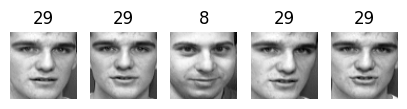


Cluster 1: número de imágenes totales = 5. Mostrando 5 imágenes.


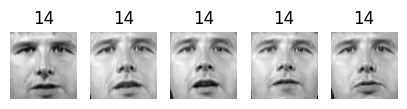


Cluster 2: número de imágenes totales = 2. Mostrando 2 imágenes.


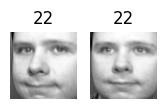


Cluster 3: número de imágenes totales = 3. Mostrando 3 imágenes.


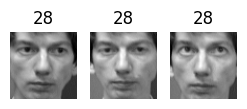


Cluster 4: número de imágenes totales = 2. Mostrando 2 imágenes.


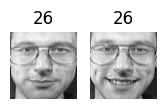


Cluster 5: número de imágenes totales = 4. Mostrando 4 imágenes.


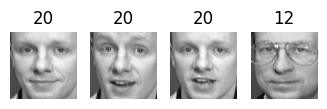


Cluster 6: número de imágenes totales = 1. Mostrando 1 imágenes.


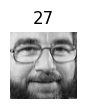


Cluster 7: número de imágenes totales = 3. Mostrando 3 imágenes.


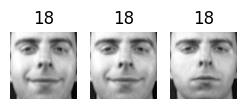


Cluster 8: número de imágenes totales = 3. Mostrando 3 imágenes.


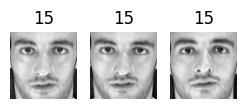


Cluster 9: número de imágenes totales = 2. Mostrando 2 imágenes.


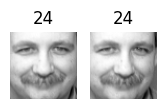

In [23]:
cluster_labels = best_model.labels_

# Convertimos X_train a un array de numpy 
# (.iloc lo dejamos en su formato original)
# X_train_original = X_train.values 

# Para cada uno de los 10 primeros clústeres, seleccionamos las imágenes correspondientes del conjunto de entrenamiento
for cluster in range(10):
    # Obtenemos los índices de las imágenes 
    indices = np.where(cluster_labels == cluster)[0]
    
    # Verificamos que el clúster tenga al menos una imagen
    if len(indices) == 0:
        print(f"Cluster {cluster} no contiene imágenes.")
        continue
    
    # Solo las primeras 10 para visualizar
    n_show = min(10, len(indices))
    
    # Extraemos las imágenes 
    faces_cluster = X_train.iloc[indices[:n_show]].values  # Cada fila es un vector
    labels_cluster = y_train.iloc[indices[:n_show]].values   # Las etiquetas (aunque en clustering no se usan para agrupar)
    
    print(f"\nCluster {cluster}: número de imágenes totales = {len(indices)}. Mostrando {n_show} imágenes.")
    plot_faces(faces_cluster, labels_cluster, n_cols=5)

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Crear y entrenar el clasificador RandomForest con 150 estimadores
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
rf_clf.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de validación
y_valid_pred = rf_clf.predict(X_valid)

# Calcular y mostrar la exactitud (accuracy)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print("Validation Accuracy:", accuracy_valid)

Validation Accuracy: 0.925


### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [25]:
# Transformar los conjuntos de datos usando el modelo best_model
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

# Entrenar el RandomForest sobre los datos transformados (nuevos features: distancias a centroides)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_reduced = RandomForestClassifier(n_estimators=150, random_state=42)
rf_reduced.fit(X_train_reduced, y_train)

# Ver
y_valid_pred_reduced = rf_reduced.predict(X_valid_reduced)
accuracy_valid_reduced = accuracy_score(y_valid, y_valid_pred_reduced)
print("Validation Accuracy con datos reducidos:", accuracy_valid_reduced)

Validation Accuracy con datos reducidos: 0.775


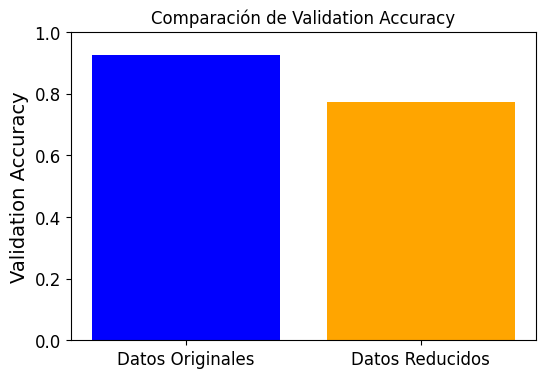

In [26]:
# Datos a graficar
accuracies = {
    "Datos Originales": 0.925,
    "Datos Reducidos": 0.775
}

# Barras
plt.figure(figsize=(6,4))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel("Validation Accuracy")
plt.title("Comparación de Validation Accuracy")
plt.show()

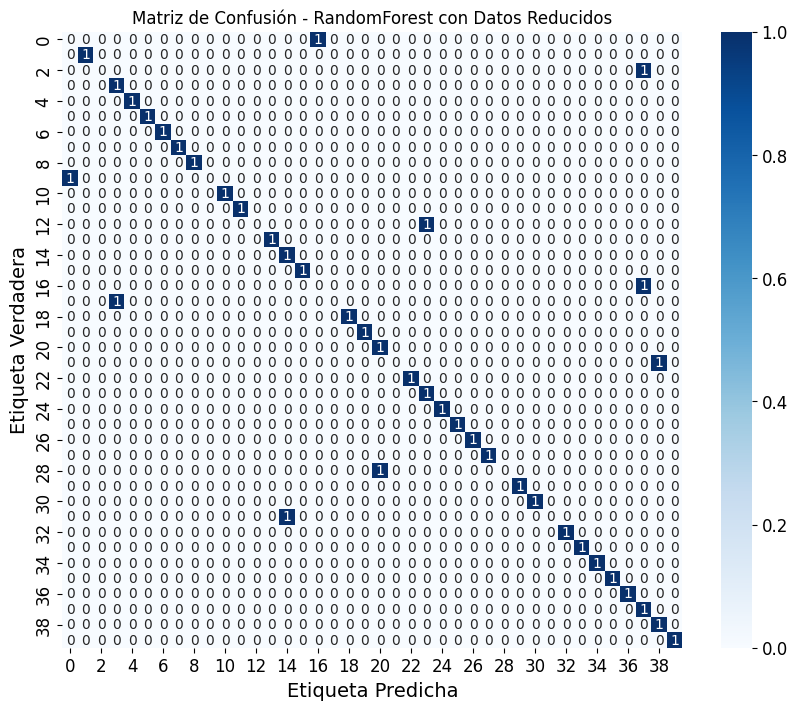

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión para el conjunto de validación
cm = confusion_matrix(y_valid, y_valid_pred_reduced)

# Graficar 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - RandomForest con Datos Reducidos")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)